##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [18]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# pool.close()

In [19]:
def Curve(x,a,b,c):
    return (a/(b+x)**c)

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

def TTV_Split(iteration,Memory,X,y,params,X_fill,Save):
    seed = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    iteration = int(iteration/params['splits_per_mod'])
    print(seed,iteration)
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=seed)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=seed)
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,iteration,seed,X_fill = X_fill,Memory=Memory,Save=Save),
        y_val)

def RunReps(Model,params,pool = None,FullReturn=False,Save=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill,
                                                     Save=Save),range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1][0].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill,Save)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(y_val,Yval))
            R2.append(metrics.r2_score(y_val,Yval))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    return(MSE,R2,RST.Master['TempFill'])

In [20]:
FillVar = 'fch4'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
FullModel = ['PPFD_Avg','AirTC_Avg','Sedge','VWC','Grass']
Runs,params = Dense.Params('Test',FillVar,MP=False)
print(params)

# Data = pd.read_csv(Path)
# Data = Data.set_index(pd.DatetimeIndex(Data.datetime))

{'proc': 1, 'K': 4, 'epochs': 100, 'Y': 'fch4', 'splits_per_mod': 2}


In [21]:
Time = time.time()
Path = 'Data_Footprints_2018-06-12.csv'
if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
def RunLoop(Runs):
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MSE']=MSE
        Runs.loc[Runs['N']==N,'R2']=R2
        print(Runs.loc[Runs['N']==N])
    return(Runs)
Runs = RunLoop(Runs)

0 0
50 0
0 1
50 1
   N        MSE        R2  Model
0  4  86.452416  0.460402      0
1  4  56.665841  0.555579      0
2  4  83.689914  0.477644      0
3  4  64.592273  0.493413      0
0 0
50 0
0 1
50 1
    N        MSE        R2  Model
4  16  49.762331  0.689405      0
5  16  33.856954  0.734465      0
6  16  52.698844  0.671077      0
7  16  42.235606  0.668753      0
0 0
50 0
0 1
50 1
     N        MSE        R2  Model
8   36  50.242512  0.686408      0
9   36  36.362372  0.714816      0
10  36  48.230509  0.698966      0
11  36  33.156091  0.739962      0


In [22]:
# FullModel = ['PPFD_Avg','AirTC_Avg']

In [23]:
# from keras.models import model_from_json
# json_file = open('Weights/model0.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("Weights/0_0.h5")
# print("Loaded model from disk")


# plt.figure(figsize=(10,10))
# for i in range(2):
#     RST = RSTF.ReadStandardTimeFill(Path)
#     RST.Scale(params['Y'],FullModel)
#     y = RST.y*1.0
#     X = RST.X*1.0
#     if i == 0:
#         X[:,0]=X[:,0].min()
#     if i == 1:
#         X[:,0]=X[:,0].mean()
# #     if i == 2:
# #         X[:,0]=X[:,0].max()
#     loaded_model.compile(loss='mean_squared_error', optimizer='adam')#loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     score = loaded_model.evaluate(X, y, verbose=1)
#     rest = loaded_model.predict(X)
#     rest = RST.YScaled.inverse_transform(rest.reshape(-1,1))
#     X = RST.XScaled.inverse_transform(X)
#     print(score)
#     plt.scatter(X[:,1],rest,label=X[:,0].mean())
# plt.legend()


# The "Optimum" Sized Model

          MSE        R2  Model         SD        SE
N                                                  
4   72.850111  0.496759      0  14.521783  7.260891
16  44.638434  0.690925      0   8.430864  4.215432
36  41.997871  0.710038      0   8.500114  4.250057


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


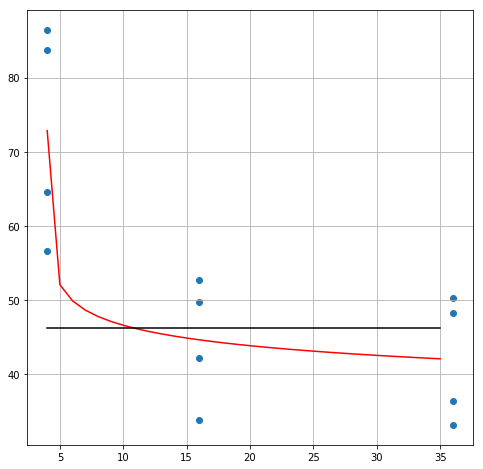

11 46.24792784736832
53.70396614074707


In [24]:

Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)
N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
plt.grid()
plt.show()
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'],Max)
print(time.time()-Time)

# Feature Identification

In [25]:
Scores = Runs[['MSE','R2']].reset_index(drop=True)
Scores = (Scores.iloc[0:params['K']])*0
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)

Results = RunReps(FullModel,params,pool)

MSE = Results[0]
R2 = Results[1]
# mean,std = np.asanyarray(MSE).mean(),np.asanyarray(MSE).std()
# CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
Scores['MSE']=Results[0]#MSE#mean
Scores['R2']=Results[1]#R2#.mean()

ModelRuns = Results[2]
ModelRuns = ModelRuns.to_frame()
ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
ModelRuns=ModelRuns.drop('TempFill',axis=1)
print(Scores)

0 0
50 0
0 1
50 1
         MSE        R2  Level  Key                               Model
0  58.541215  0.634611      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
1  42.468487  0.666926      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
2  57.700480  0.639859      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
3  51.034873  0.599742      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass


In [26]:
for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    Values = []
    Names = []
    for i,model in enumerate(Models):
        level = len(model)
        key = str(level)+'_'+str(i)
        Name = '+'.join(model)
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+Name
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        R2 = Results[1]
        d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
        score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
        Scores = Scores.append(score,ignore_index=True)
        print(Scores.loc[Scores['Key']==key])
        ModelRuns['Model: '+'+'.join(model)] = Results[2]    
    Group = Scores.groupby('Key').agg({'Model': 'first', 
                                            'Level': 'first', 
                                            'MSE': 'mean', 
                                            'R2': 'mean'})#.reset_index()#mean()  
    Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
    Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]
    Best = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
    print(Best)
    

Level:  1
0 0
50 0
0 1
50 1


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


   Key  Level         MSE     Model        R2
4  1_0      1  156.928759  PPFD_Avg  0.020519
5  1_0      1  111.500804  PPFD_Avg  0.125517
6  1_0      1  160.275501  PPFD_Avg -0.000370
7  1_0      1  112.999256  PPFD_Avg  0.113765
0 0
50 0
0 1
50 1
    Key  Level         MSE      Model        R2
8   1_1      1  144.679532  AirTC_Avg  0.096973
9   1_1      1  106.692538  AirTC_Avg  0.163227
10  1_1      1  144.785640  AirTC_Avg  0.096311
11  1_1      1  105.806188  AirTC_Avg  0.170179
0 0
50 0
0 1
50 1
    Key  Level         MSE  Model        R2
12  1_2      1  132.513821  Sedge  0.172906
13  1_2      1  102.942992  Sedge  0.192634
14  1_2      1  133.338375  Sedge  0.167760
15  1_2      1  110.322274  Sedge  0.134760
0 0
50 0
0 1
50 1
    Key  Level         MSE Model        R2
16  1_3      1  145.962868   VWC  0.088963
17  1_3      1  119.087847   VWC  0.066013
18  1_3      1  144.894838   VWC  0.095629
19  1_3      1  119.577213   VWC  0.062175
0 0
50 0
0 1
50 1
    Key  Level         

                                  Model  Level         MSE        R2  \
Key                                                                    
1_2                               Sedge      1  119.779365  0.167015   
2_2                           Sedge+VWC      2   64.625987  0.550923   
3_0                  PPFD_Avg+Sedge+VWC      3   54.769283  0.622033   
4_1            PPFD_Avg+Sedge+VWC+Grass      4   51.661734  0.644049   
5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5   52.436264  0.635284   

            SD        SE  
Key                       
1_2  15.480236  7.740118  
2_2   8.874170  4.437085  
3_0  11.270103  5.635052  
4_1  11.610177  5.805088  
5_0   7.445421  3.722710  
                Model  Level        MSE        R2         SD        SE
2  PPFD_Avg+Sedge+VWC      3  54.769283  0.622033  11.270103  5.635052
0 0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


50 0
0 1
50 1
   N        MSE        R2  Model
0  4  86.451533  0.460407      0
1  4  56.663666  0.555596      0
2  4  83.724931  0.477425      0
3  4  64.584409  0.493475      0
0 0
50 0
0 1
50 1
    N        MSE        R2  Model
4  16  49.759454  0.689423      0
5  16  33.857783  0.734459      0
6  16  52.697319  0.671086      0
7  16  42.234299  0.668763      0
0 0
50 0
0 1
50 1
     N        MSE        R2  Model
8   36  49.930280  0.688357      0
9   36  36.330119  0.715069      0
10  36  48.360029  0.698158      0
11  36  33.165266  0.739890      0
          MSE        R2  Model         SD        SE
N                                                  
4   72.850111  0.496759      0  14.521783  7.260891
16  44.638434  0.690925      0   8.430864  4.215432
36  41.997871  0.710038      0   8.500114  4.250057
11


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


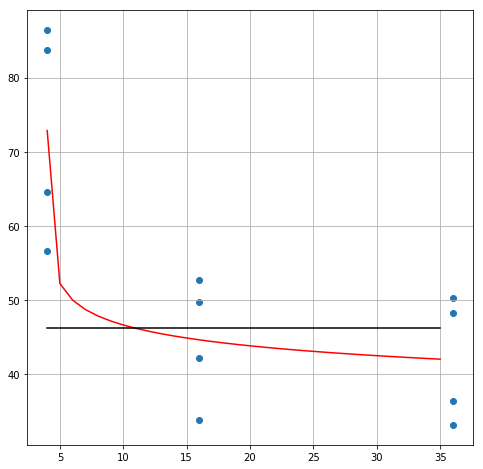

11


In [27]:
Group = Scores.groupby('Key').agg({'Model': 'first', 
                                        'Level': 'first', 
                                        'MSE': 'mean', 
                                        'R2': 'mean'})#.reset_index()#mean()  
Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
Min = Group.loc[Group['Level']==level]

Levels = Group.groupby('Level').min()
Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
print(Sub)
Sub.sort_values('Level',inplace=True)
Sub = Sub.loc[Sub['Level']>=1]
Sub.reset_index(inplace=True,drop=True)
Min = Sub.loc[Sub['MSE']==Sub['MSE'].min()]
Parsimony = (Sub.loc[Sub['MSE']<(Min['MSE'].values+Min['SE'].values)[0]])
Parsimony = Parsimony.loc[Parsimony['Level']==Parsimony['Level'].min()]
print(Parsimony)
Best = Parsimony['Model'].values

def Curve(x,a,b,c):
    return (a/(b+x)**c)

N = Runs['N']
NRuns = Runs*0
NRuns['N']=N

model = Best[0].split('+')
NRuns = RunLoop(NRuns)
Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, NRuns['N'].values, NRuns['MSE'].values)

N = np.arange(NRuns['N'].min(),NRuns['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'])
plt.grid()
plt.show()
print(params['N'])

In [28]:
level = 0#len(Best)
print(Best)
key = '0_'+str(params['N'])
Name = '+'.join(Best)
NewRow = Scores.iloc[-1].copy()
NewRow['Model'] = 'BestModel: '+Name
Results = RunReps(model,params,pool,Save=True)

# Results = RunReps(FullModel,params,pool)
MSE = Results[0]
# for mse in MSE:
#     Names.append(Name)
#     Values.append(mse)
# mean,std = MSE.mean(),MSE.std()
# CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
R2 = Results[1]
d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
Scores = Scores.append(score,ignore_index=True)
Scores = Scores.append(score,ignore_index=True)
ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
print(params['N'])
print(Scores)

['PPFD_Avg+Sedge+VWC']
0 0
Saved model to disk
50 0
Saved model to disk
0 1
Saved model to disk
50 1
Saved model to disk
11
     Key  Level         MSE                               Model        R2
0    5_0      5   58.541215  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.634611
1    5_0      5   42.468487  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.666926
2    5_0      5   57.700480  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.639859
3    5_0      5   51.034873  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.599742
4    1_0      1  156.928759                            PPFD_Avg  0.020519
5    1_0      1  111.500804                            PPFD_Avg  0.125517
6    1_0      1  160.275501                            PPFD_Avg -0.000370
7    1_0      1  112.999256                            PPFD_Avg  0.113765
8    1_1      1  144.679532                           AirTC_Avg  0.096973
9    1_1      1  106.692538                           AirTC_Avg  0.163227
10   1_1      1  144.785640                           AirTC_Av

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [29]:
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
ModelRuns.to_csv('GapFilled'+FillVar+'.csv')

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)

458.6533782482147


Loaded model from disk


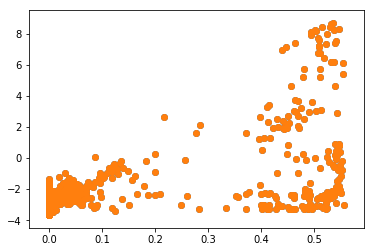

In [30]:
from keras.models import model_from_json

import ReadStandardTimeFill as RSTF
json_file = open('C:/Users/wesle/ML_GapFilling/Weights/model0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/Users/wesle/ML_GapFilling/Weights/0_0.h5")
print("Loaded model from disk")


# plt.figure(figsize=(10,10))
# FullModel = fco2_summary.loc[fco2_summary['Level']==0,'Model'].values[0].split('+')

for i in range(2):
    RST = RSTF.ReadStandardTimeFill('Data_Footprints_2018-06-12.csv')
    RST.Scale('fco2',model)
    y = RST.y*1.0
    X = RST.X*1.0
#     if i == 0:
#         X[:,0]=X[:,0].min()
#     if i == 1:
#         X[:,0]=X[:,0].mean()
#     if i == 2:
#         X[:,0]=X[:,0].max()
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')#loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     score = loaded_model.evaluate(X, y, verbose=1)
    rest = loaded_model.predict(X)
    rest = RST.YScaled.inverse_transform(rest.reshape(-1,1))
    X = RST.XScaled.inverse_transform(X)
#     print(score)
    plt.scatter(X[:,1],rest,label=X[:,0].mean())
# plt.legend()